## Merge movil y fijo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5, 2)
plt.rcParams['figure.dpi'] = 140

from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import datasets

Leemos los datos ya consolidados:

In [2]:
df1 = pd.read_csv('fijo_consolidado.txt', sep='\t')
df2 = pd.read_csv('base_completa_movil.csv', encoding='latin-1')

Unificamos los nombres de Columnas

In [3]:
df2 = df2[['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn', 'nota_sem']]
df1 = df1[['encriptado', 'MES', 'SEGMENTO', 'MONTO', 'RECLAMO_COM', 'RECLAMO_TEC', 'CHURN']]
df1.columns = ['encriptado', 'periodo', 'segmento', 'total', 'n_recl_com', 'n_recl_tec', 'n_churn']

Cambiamos la escala de tiempo:

In [4]:
df1.loc[df1['periodo'] <= 6, 'periodo2'] = '2019_q1'
df1.loc[(df1['periodo'] > 6) & (df1['periodo'] <= 12), 'periodo2'] = '2019_q2'
df1.loc[(df1['periodo'] > 12) & (df1['periodo'] <= 18), 'periodo2'] = '2020_q1'
df1.loc[(df1['periodo'] > 18) & (df1['periodo'] <= 24), 'periodo2'] = '2020_q2'

df1.drop('periodo', axis=1, inplace=True)
df1.rename(columns = {'periodo2': 'periodo'}, inplace=True)

Agrupamos la base de productos fijos:

In [5]:
df1 = df1.groupby(by=['encriptado', 'segmento', 'periodo'],
                  as_index=False).agg({'total': np.mean,
                                       'n_recl_com': np.sum,
                                       'n_recl_tec': np.sum,
                                       'n_churn': np.sum})

In [6]:
df2 = df2.groupby(by=['encriptado', 'segmento', 'periodo'],
                  as_index=False).agg({'total': np.mean,
                                       'n_recl_com': np.sum,
                                       'n_recl_tec': np.sum,
                                       'n_churn': np.sum})

Unificamos:

In [7]:
df1.loc[:, 'tipo'] = 'Fijo'
df2.loc[:, 'tipo'] = 'Movil'
df = pd.concat([df1, df2], axis=0)

In [8]:
l1 = ['MICRO Y SOHO', 'MEDIANAS', 'S/I', 'EMPRESAS', 'GRANDES CUENTAS',
      'PEQUENAS', 'GRANDES CLIENTES', 'empresas']
l2 = ['masivos', 'mmee', 's/i', 'ggee', 'ggee', 'masivos', 'ggee', 'ggee']

df.loc[:, 'segmento'] = df['segmento'].replace(l1, l2)

df3 = df.groupby(by=['encriptado', 'segmento', 'periodo', 'tipo'], as_index=False).sum()

Filtramos:

In [9]:
df3 = df3.loc[(df3['total'] >= 1000) & (df3['total'] <= 10000000), :]
df3 = df3.loc[df3['n_recl_com'] <= 10, :]
df3 = df3.loc[df3['n_recl_tec'] <= 10, :]

df3.loc[:, 'log_total'] = np.log(df3['total'])
df3.loc[:, 'churn'] = 0
df3.loc[df3['n_churn']>0, 'churn'] = 1

In [10]:
df3.sort_values(by=['encriptado', 'segmento', 'tipo', 'periodo'], inplace=True)
df3.reset_index(drop=True, inplace=True)

In [11]:
df3['n_recl_com_cumsum'] = df3.groupby(['encriptado', 'segmento', 'tipo'])['n_recl_com'].transform(pd.Series.cumsum)
df3['n_recl_tec_cumsum'] = df3.groupby(['encriptado', 'segmento', 'tipo'])['n_recl_tec'].transform(pd.Series.cumsum)

## Gráficos

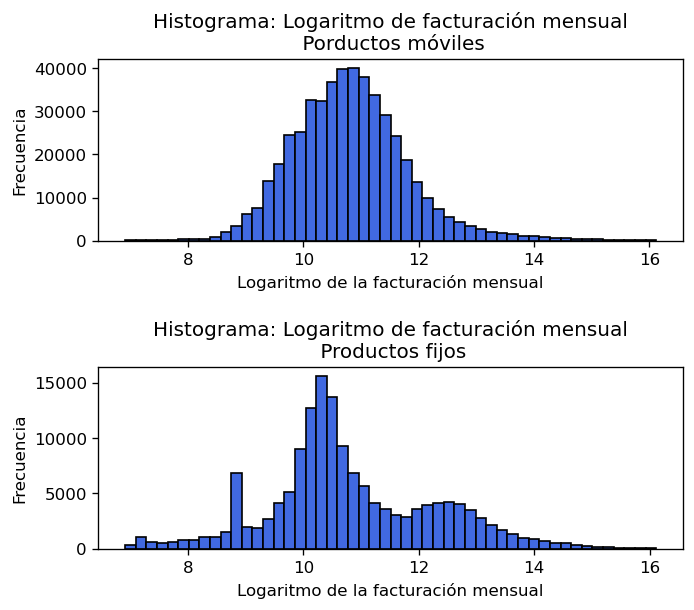

In [12]:
plt.figure(figsize=(6, 5), dpi=120)

plt.subplot(2,1,1)
plt.tight_layout()

plt.hist(data= df3[df3['tipo'] == 'Movil'], x = 'log_total',
         bins=50, histtype='bar', ec='black', facecolor = 'royalblue')
plt.xlabel("Logaritmo de la facturación mensual")
plt.ylabel("Frecuencia")
plt.title("Histograma: Logaritmo de facturación mensual\n Porductos móviles")

plt.subplot(2,1,2)
plt.tight_layout()
plt.hist(data= df3[df3['tipo'] == 'Fijo'], x = 'log_total',
         bins=50, histtype='bar', ec='black', facecolor = 'royalblue')
plt.xlabel("Logaritmo de la facturación mensual")
plt.ylabel("Frecuencia")
plt.title("Histograma: Logaritmo de facturación mensual\n Productos fijos")
plt.subplots_adjust(hspace=0.7)

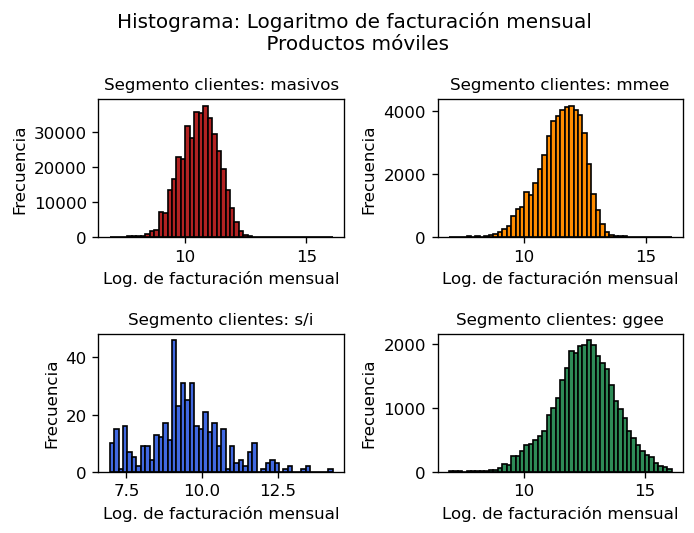

In [13]:
plt.figure(figsize=(6, 4), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
for i, row_n in enumerate(df['segmento'].unique()):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.hist(data= df3[(df3['tipo'] == 'Movil') & (df3['segmento'] == row_n)],
           x = 'log_total', bins=50, histtype='bar', ec='black',
           facecolor=colores[i])
    plt.xlabel("Log. de facturación mensual", fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.title("Segmento clientes: "+row_n, fontsize=10)
plt.suptitle("Histograma: Logaritmo de facturación mensual\n Productos móviles",
            y=1.1)
plt.subplots_adjust(hspace=0.7)

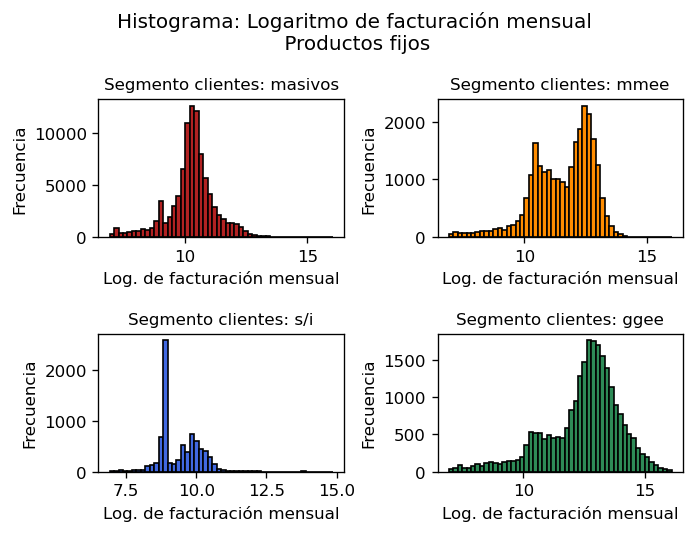

In [14]:
plt.figure(figsize=(6, 4), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
for i, row_n in enumerate(df['segmento'].unique()):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.hist(data= df3[(df3['tipo'] == 'Fijo') & (df3['segmento'] == row_n)],
           x = 'log_total', bins=50, histtype='bar', ec='black',
           facecolor=colores[i])
    plt.xlabel("Log. de facturación mensual", fontsize=10)
    plt.ylabel("Frecuencia", fontsize=10)
    plt.title("Segmento clientes: "+row_n, fontsize=10)
plt.suptitle("Histograma: Logaritmo de facturación mensual\n Productos fijos",
            y=1.1)
plt.subplots_adjust(hspace=0.7)

In [15]:
rank = ['s/i', 'masivos', 'mmee', 'ggee']

Text(0.5, 1.0, 'Gráfico de densidades del logaritmo\ndel total de productos fijos\npor segmento y por churn')

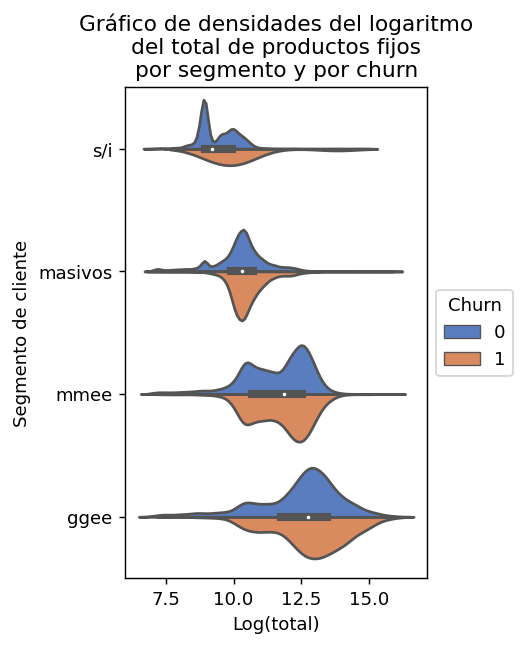

In [16]:
plt.figure(figsize=(3, 5), dpi=130)
sns.violinplot(y="segmento", x="log_total", hue="churn",
               data=df3[df3['tipo']=='Fijo'], palette="muted", split=True, 
               order=rank)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           ncol=1, title = 'Churn')
plt.ylabel('Segmento de cliente')
plt.xlabel('Log(total)')
plt.title('Gráfico de densidades del logaritmo\ndel total de productos fijos\npor segmento y por churn')

In [38]:
for seg in df3['segmento'].unique():
    tdf = df3[(df3['segmento'] == seg) & (df3['churn'] == 1)]
    print('Segmento:', seg)
    print('   La media es:', tdf['log_total'].mean())
    print('   La std es:', tdf['log_total'].std())

for seg in df3['segmento'].unique():
    tdf = df3[(df3['segmento'] == seg) & (df3['churn'] == 0)]
    print('Segmento:', seg)
    print('   La media es:', tdf['log_total'].mean())
    print('   La std es:', tdf['log_total'].std())

Segmento: masivos
   La media es: 10.651371111206341
   La std es: 0.8141005987542322
Segmento: mmee
   La media es: 11.746495120132652
   La std es: 0.8985985879961899
Segmento: s/i
   La media es: 10.149344976009079
   La std es: 1.2233691310509143
Segmento: ggee
   La media es: 13.001752134785328
   La std es: 1.2567268654789343
Segmento: masivos
   La media es: 10.502210318993315
   La std es: 0.8265159889104433
Segmento: mmee
   La media es: 11.490688570703039
   La std es: 1.0586816378948671
Segmento: s/i
   La media es: 9.405404667309707
   La std es: 0.7661053622421183
Segmento: ggee
   La media es: 12.31268336674126
   La std es: 1.40065968480778


Text(0.5, 1.0, 'Gráfico de densidades del logaritmo\ndel total de productos móviles\npor segmento y por churn')

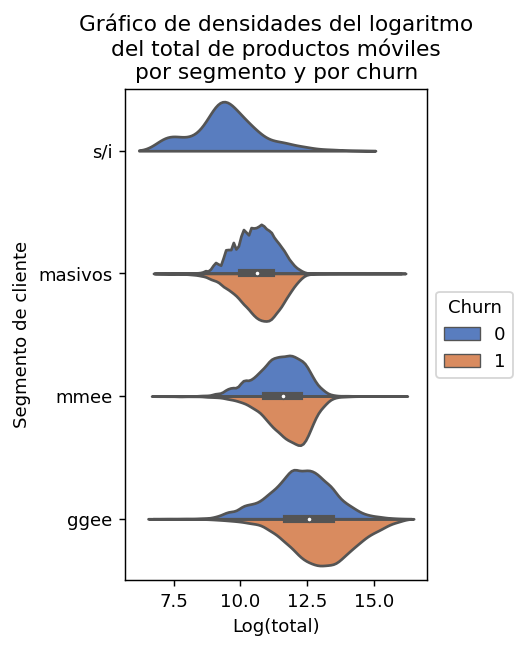

In [51]:
plt.figure(figsize=(3, 5), dpi=130)
sns.violinplot(y="segmento", x="log_total", hue="churn",
               data=df3[df3['tipo']=='Movil'], palette="muted", split=True, 
               order=rank)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           ncol=1, title = 'Churn')
plt.ylabel('Segmento de cliente')
plt.xlabel('Log(total)')
plt.title('Gráfico de densidades del logaritmo\ndel total de productos móviles\npor segmento y por churn')

In [17]:
'''sns.catplot(x="segmento", y="log_total", hue='churn',
            row = 'tipo',  order=rank, kind="violin", split=True,
            data=df3, palette="muted", height=4)
plt.ylabel("Log. de factuación mensual")'''

'sns.catplot(x="segmento", y="log_total", hue=\'churn\',\n            row = \'tipo\',  order=rank, kind="violin", split=True,\n            data=df3, palette="muted", height=4)\nplt.ylabel("Log. de factuación mensual")'

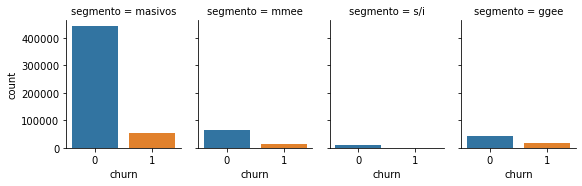

In [16]:
'''sns.catplot(x="churn", col="segmento", col_wrap=4,
            data = df3,
            kind="count",
            height=2.5, aspect=.8)'''

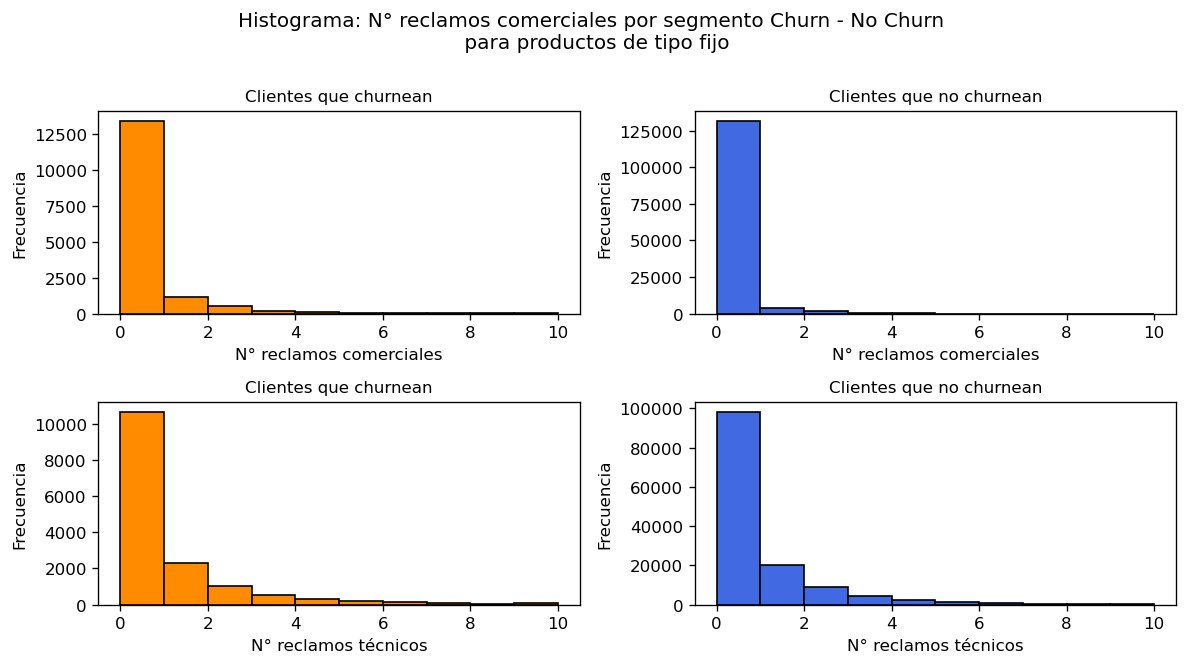

In [29]:
plt.figure(figsize=(10, 5), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
plt.subplot(2,2,1)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==1)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,2)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==0)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.suptitle("Histograma: N° reclamos comerciales por segmento Churn - No Churn \n para productos de tipo fijo",
            y=1.1)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()


plt.subplot(2,2,3)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==1)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,4)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Fijo') & (df3['churn']==0)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.tight_layout()

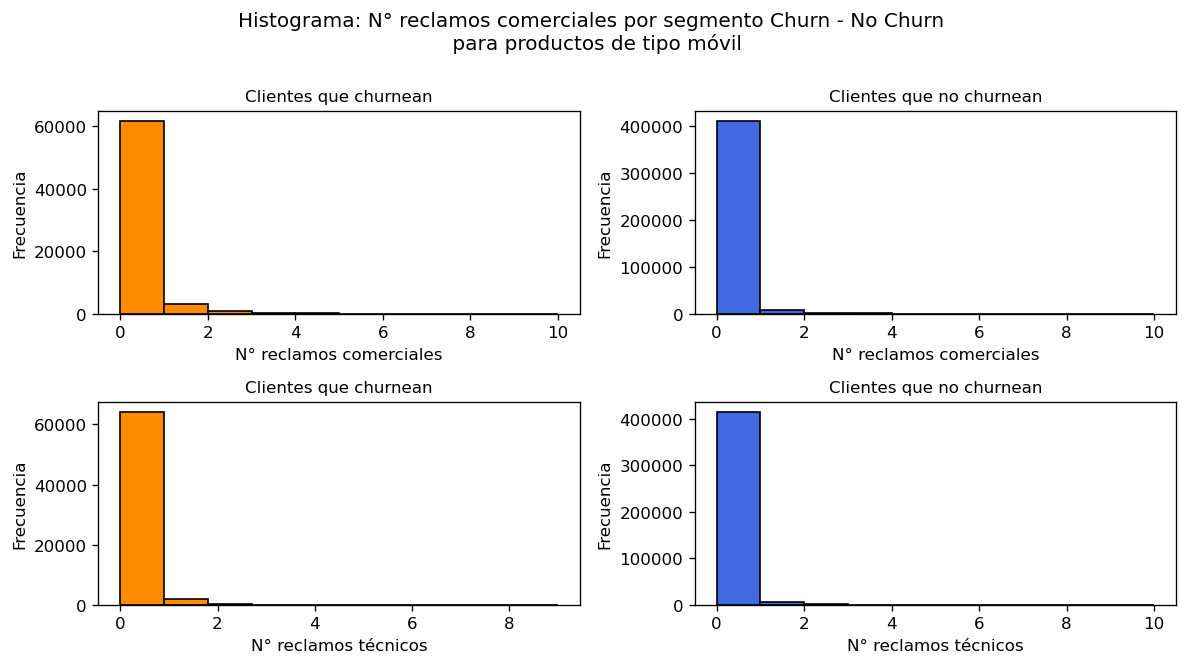

In [28]:
plt.figure(figsize=(10, 5), dpi=120)
colores = ['firebrick', 'darkorange', 'royalblue', 'seagreen']
plt.subplot(2,2,1)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==1)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,2)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==0)],
         x = 'n_recl_com', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos comerciales", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.suptitle("Histograma: N° reclamos comerciales por segmento Churn - No Churn \n para productos de tipo móvil",
            y=1.1)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()


plt.subplot(2,2,3)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==1)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[1])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que churnean", fontsize=10)

plt.subplot(2,2,4)
plt.tight_layout()

plt.hist(data = df3[(df3['tipo'] == 'Movil') & (df3['churn']==0)],
         x = 'n_recl_tec', rwidth=1, histtype='bar', ec='black',
         facecolor=colores[2])
plt.xlabel("N° reclamos técnicos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

plt.title("Clientes que no churnean", fontsize=10)

plt.tight_layout()

## Dividimos dataset en train y test y aplicamos RUS

In [30]:
y = df3['churn']

x = df3.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo'], axis=1)

x = pd.get_dummies(x, columns = ['segmento'])
x = pd.get_dummies(x, columns = ['tipo'])

x= StandardScaler().fit_transform(x)

In [31]:
df_train = df3[df3['periodo'].isin(['2019_q1', '2019_q2', '2020_q1'])]
df_test = df3[df3['periodo'].isin(['2020_q2'])]

dftrain_y = df_train['churn']
dftest_y = df_test['churn']

dftrain = df_train.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo'], axis=1)

dftest = df_test.drop(['churn', 'n_churn', 'total',
              'encriptado', 'periodo'], axis=1)

x1 = pd.get_dummies(dftrain, columns = ['segmento', 'tipo'])
x2 = pd.get_dummies(dftest, columns = ['segmento', 'tipo'])

x1 = StandardScaler().fit_transform(x1)
x2 = StandardScaler().fit_transform(x2)

In [32]:
rus = RandomUnderSampler(random_state=0)
#rus = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x1, dftrain_y)

In [33]:
rus = RandomUnderSampler(random_state=0)
#rus = RandomOverSampler(random_state=0)
X_resampled2, y_resampled2 = rus.fit_resample(x2, dftest_y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

# Probando AutoML

In [14]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML

  Created wheel for h2o: filename=h2o-3.32.1.3-py2.py3-none-any.whl size=164854348 sha256=dc321b6a06fb7de6e8f9bf051de7c1e38f4a92bc478e4d38f9906d54e86d5e2c
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\94\de\98\a3badf41ac2c2b02dc1a21c9b8f8d435b5eb68a52f9df8d3c1
Successfully built h2o


In [15]:
#Pasamos el dataframe a H2o df
df3.v2 = df3.drop(['n_churn', 'total',
              'encriptado', 'periodo', 'nota_sem'], axis=1)
df3.v2 = pd.get_dummies(df3.v2, columns = ['segmento'])
df3.v2 = pd.get_dummies(df3.v2, columns = ['tipo'])

train, test = train_test_split(df3.v2, test_size=0.2)


h2o.init()

# Identify predictors and response
x = list(train.columns)
y = "churn"
x.remove(y)

# For binary classification, response should be a factor
train["churn"] = train["churn"].astype('category')
test["churn"] = test["churn"].astype('category')

train=h2o.H2OFrame(train)


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

<ipython-input-15-29af623085f1>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df3.v2 = df3.drop(['n_churn', 'total',


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from C:\Users\Asus\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Asus\AppData\Local\Temp\tmpkjwn4ha9
  JVM stdout: C:\Users\Asus\AppData\Local\Temp\tmpkjwn4ha9\h2o_Asus_started_from_python.out
  JVM stderr: C:\Users\Asus\AppData\Local\Temp\tmpkjwn4ha9\h2o_Asus_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_Asus_kkfstp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.434 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


<ipython-input-15-29af623085f1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["churn"] = train["churn"].astype('category')
<ipython-input-15-29af623085f1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["churn"] = test["churn"].astype('category')


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
14:27:51.501: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████ (cancelled)  99%


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_995a6b2d57eb2d50414149c47a1f4f40> was cancelled by the user.

In [ ]:
test=h2o.H2OFrame(test)
preds = aml.leader.predict(test)
preds

## SVM 

In [38]:
svm = LinearSVC(random_state=0, tol=0.001, max_iter=20000)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64     16266
           1       0.63      0.49      0.55     16453

    accuracy                           0.60     32719
   macro avg       0.60      0.60      0.59     32719
weighted avg       0.60      0.60      0.59     32719



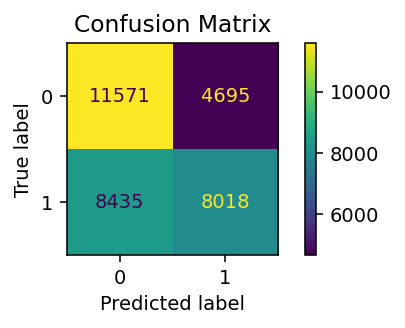

In [39]:
plot_confusion_matrix(svm, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

In [ ]:
# # defining parameter range
# param_grid = {#'C': [0.1, 10, 100, 1000], 
#               #'gamma': [1, 0.01, 0.0001],
#              'kernel': ['rbf','linear']} 

# grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................kernel=rbf;, score=0.606 total time=45.9min
[CV 2/5] END ........................kernel=rbf;, score=0.603 total time=36.8min
[CV 3/5] END ........................kernel=rbf;, score=0.606 total time=48.6min
[CV 4/5] END ........................kernel=rbf;, score=0.607 total time=44.9min
[CV 5/5] END ........................kernel=rbf;, score=0.608 total time=50.5min
[CV 1/5] END .....................kernel=linear;, score=0.592 total time=28.0min
[CV 2/5] END .....................kernel=linear;, score=0.594 total time=29.9min
[CV 3/5] END .....................kernel=linear;, score=0.592 total time=27.7min
[CV 4/5] END .....................kernel=linear;, score=0.586 total time=30.6min
[CV 5/5] END .....................kernel=linear;, score=0.595 total time=27.2min


In [ ]:
# # defining parameter range
# param_grid = {#'C': [0.1, 10, 100, 1000], 
#               #'gamma': [1, 0.01, 0.0001],
#               'kernel': [ 'poly', 'sigmoid']} 

# grid_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# #fitting the model for grid search
# grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ......................kernel=poly;, score=0.605 total time=121.0min
[CV 2/5] END ......................kernel=poly;, score=0.602 total time=128.1min
[CV 3/5] END ......................kernel=poly;, score=0.602 total time=119.5min
[CV 4/5] END ......................kernel=poly;, score=0.605 total time=122.3min
[CV 5/5] END ......................kernel=poly;, score=0.606 total time=129.0min
[CV 1/5] END ....................kernel=sigmoid;, score=0.495 total time=31.6min
[CV 2/5] END ....................kernel=sigmoid;, score=0.499 total time=51.7min
[CV 3/5] END ....................kernel=sigmoid;, score=0.499 total time=53.0min
[CV 4/5] END ....................kernel=sigmoid;, score=0.499 total time=56.9min
[CV 5/5] END ....................kernel=sigmoid;, score=0.520 total time=25.8min


In [ ]:
grid_svm.best_params_

### SVM con rbf (Gausiano)

In [36]:
start = time.time()
svmG = SVC(kernel='rbf')
svmG.fit(X_train, y_train)

y_pred = svmG.predict(X_test)
print(classification_report(y_test, y_pred))
end = time.time()
print (" SVC RBF", end - start)

              precision    recall  f1-score   support

           0       0.57      0.85      0.68     16266
           1       0.71      0.36      0.48     16453

    accuracy                           0.60     32719
   macro avg       0.64      0.61      0.58     32719
weighted avg       0.64      0.60      0.58     32719

 SVC RBF 4089.5810639858246


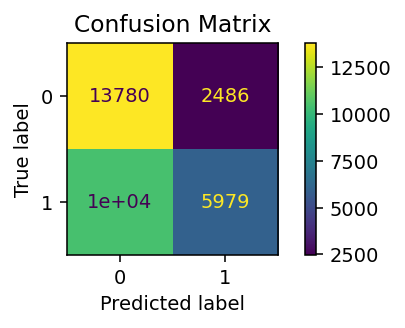

In [37]:
plot_confusion_matrix(svmG, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

 #### BaggingClassifier

In [34]:
start = time.time()
n_estimators = 10
svmGB = BaggingClassifier(SVC(kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
svmGB.fit(X_train, y_train)
y_pred = svmGB.predict(X_test)
print(classification_report(y_test, y_pred))
end = time.time()
print ("Single SVC", end - start)

              precision    recall  f1-score   support

           0       0.57      0.82      0.68     16266
           1       0.69      0.39      0.50     16453

    accuracy                           0.61     32719
   macro avg       0.63      0.61      0.59     32719
weighted avg       0.63      0.61      0.59     32719

Single SVC 1701.0504248142242


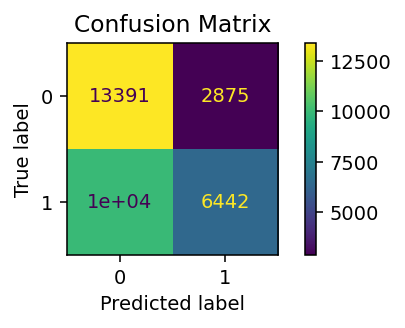

In [35]:
plot_confusion_matrix(svmGB, X_test, y_test)
plt.title('Confusion Matrix')
plt.show() 

## Logit

In [62]:
logit = LogisticRegression(random_state=0, max_iter=500).fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64     16266
           1       0.63      0.50      0.55     16453

    accuracy                           0.60     32719
   macro avg       0.60      0.60      0.60     32719
weighted avg       0.60      0.60      0.60     32719



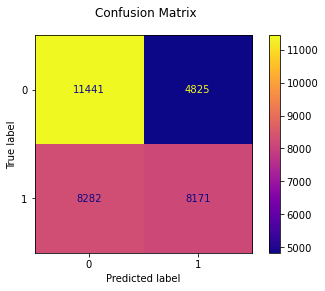

In [63]:
disp = plot_confusion_matrix(logit, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

In [58]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000],
             'tol': [0.0000001,0.00000001,0.000000001, 0.0000000000001],
             'max_iter':[100,500,1000,5000,10000]} 

grid_logit = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_logit.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.595 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.605 total time=   0.0s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.603 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-07;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.595 total time=   0.0s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.605 total time=   0.0s
[CV 3/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 4/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.603 total time=   0.0s
[CV 5/5] END ....C=0.1, max_iter=100, tol=1e-08;, score=0.600 total time=   0.0s
[CV 1/5] END ....C=0.1, max_iter=100, tol=1e-09;, score=0.595 total time=   0.1s
[CV 2/5] END ....C=0.1, max_iter=100, tol=1e-0

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'max_iter': [100, 500, 1000, 5000, 10000],
                         'tol': [1e-07, 1e-08, 1e-09, 1e-13]},
             verbose=3)

In [59]:
grid_logit.best_params_

{'C': 10, 'max_iter': 100, 'tol': 1e-07}

### Ahora obtenemos el logit óptimo:

In [105]:
logit = LogisticRegression(random_state=0, max_iter=100,tol=1e-07,C=10).fit(X_train, y_train)
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64     12499
           1       0.62      0.51      0.56     12381

    accuracy                           0.60     24880
   macro avg       0.61      0.60      0.60     24880
weighted avg       0.61      0.60      0.60     24880



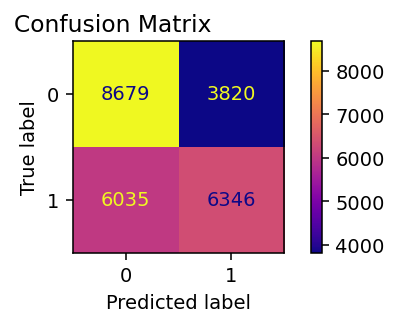

In [106]:
disp = plot_confusion_matrix(logit, X_test, y_test,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

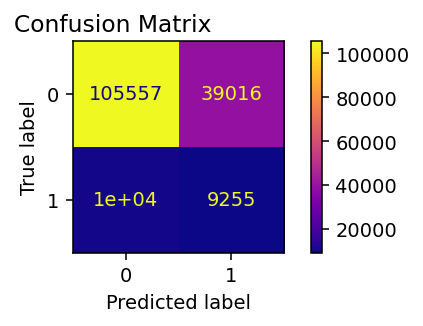

In [108]:
disp = plot_confusion_matrix(logit, x2, dftest_y,cmap='plasma')
disp.figure_.suptitle("Confusion Matrix", color="black")
plt.show()

## Random Forest

In [109]:
rf = RandomForestClassifier(
            n_estimators = 30, #El número de arboles en el bosque
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59     12499
           1       0.59      0.58      0.58     12381

    accuracy                           0.59     24880
   macro avg       0.59      0.59      0.59     24880
weighted avg       0.59      0.59      0.59     24880



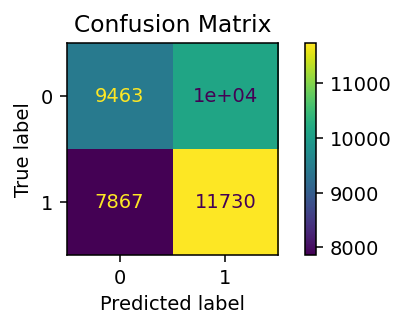

In [110]:
plot_confusion_matrix(rf, X_resampled2, y_resampled2)
plt.title('Confusion Matrix')
plt.show()

In [102]:
rf = RandomForestClassifier(
            n_estimators = 10, #El número de arboles en el bosque
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(x2)
print(classification_report(dftest_y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.51      0.65    144573
           1       0.14      0.58      0.22     19597

    accuracy                           0.52    164170
   macro avg       0.52      0.54      0.44    164170
weighted avg       0.81      0.52      0.60    164170



In [80]:
dftest_y

1         0
5         0
9         0
13        0
17        0
         ..
640165    0
640169    0
640174    0
640175    0
640179    0
Name: churn, Length: 164170, dtype: int64

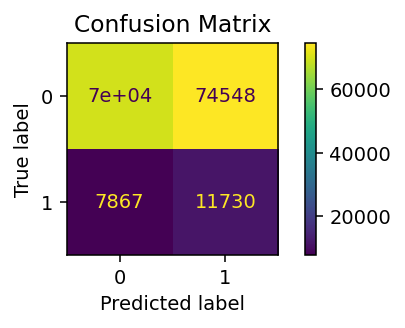

In [111]:
plot_confusion_matrix(rf, x2, dftest_y)
plt.title('Confusion Matrix')
plt.show()

In [43]:
# defining parameter range
param_grid = {'n_estimators': range(1, 16),
             'criterion': ['entropy','gini']} 

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .criterion=entropy, n_estimators=1;, score=0.592 total time=   0.3s
[CV 2/5] END .criterion=entropy, n_estimators=1;, score=0.593 total time=   0.3s
[CV 3/5] END .criterion=entropy, n_estimators=1;, score=0.586 total time=   0.3s
[CV 4/5] END .criterion=entropy, n_estimators=1;, score=0.587 total time=   0.3s
[CV 5/5] END .criterion=entropy, n_estimators=1;, score=0.587 total time=   0.4s
[CV 1/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.8s
[CV 2/5] END .criterion=entropy, n_estimators=2;, score=0.586 total time=   0.9s
[CV 3/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.9s
[CV 4/5] END .criterion=entropy, n_estimators=2;, score=0.584 total time=   0.8s
[CV 5/5] END .criterion=entropy, n_estimators=2;, score=0.581 total time=   0.7s
[CV 1/5] END .criterion=entropy, n_estimators=3;, score=0.592 total time=   1.3s
[CV 2/5] END .criterion=entropy, n_estimators=3

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'n_estimators': range(1, 16)},
             verbose=3)

In [ ]:
grid_rf.best_params_

Text(0, 0.5, 'Testing Accuracy')

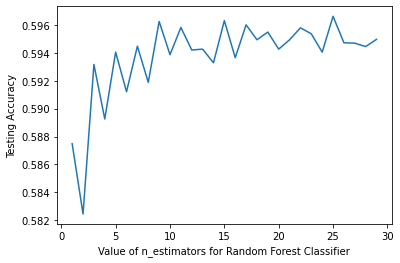

In [14]:
from sklearn.metrics import accuracy_score


scores =[]
for k in range(1, 30):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 30), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')


### Ahora obtenemos el árbol óptimo:

In [33]:
rf = RandomForestClassifier(
            n_estimators = 7,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123,
            criterion ='gini'
         )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59     16266
           1       0.60      0.59      0.60     16453

    accuracy                           0.59     32719
   macro avg       0.59      0.59      0.59     32719
weighted avg       0.59      0.59      0.59     32719



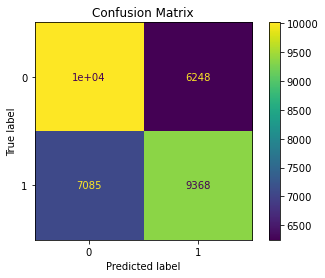

In [22]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()